In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.callbacks import TensorBoard


%matplotlib inline
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
pd.options.display.float_format = '{:.1f}'.format
labels = ['right', 'go', 'left', 'stop', 'neutral', 'omega', 'alpha']
label_cols = ['label_' + label for label in labels]

In [2]:
def load_DSs(path):
    df = pd.read_csv(path)
    df = df.reindex(np.random.permutation(df.index))
    features = df.drop(columns=['label'])
    targets = pd.get_dummies(df[['label']], prefix=None)
    targets = targets[label_cols]
    return(features, targets)

In [3]:
train_data, t_labels = load_DSs('./data/train.csv')
validation_data, v_labels = load_DSs('./data/validation.csv')
test_data, test_labels = load_DSs('./data/test.csv')

In [4]:
signal = keras.Input(shape=(200,))
x = layers.Reshape((4, 50, 1))(signal)
x = layers.Conv2D(32, (3, 5),activation='relu',padding='same')(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((1, 3))(x)
x = layers.Conv2D(64, (3, 5),activation='relu',padding='same')(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((1, 3))(x)
x = layers.Flatten()(x)
x =layers.Dense(500, activation='relu')(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs=signal, outputs=x, name='GESTURE_RECOGNITION')
model.summary()

Model: "GESTURE_RECOGNITION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 50, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 50, 32)         512       
_________________________________________________________________
dropout (Dropout)            (None, 4, 50, 32)         0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 4, 50, 32)         128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 16, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 16, 64) 

Train on 6272 samples, validate on 784 samples
Epoch 1/25
6272/6272 [==============================] - 4s 642us/sample - loss: 1.1619 - acc: 0.6161 - val_loss: 0.7312 - val_acc: 0.7500
Epoch 2/25
6272/6272 [==============================] - 3s 554us/sample - loss: 0.4971 - acc: 0.8372 - val_loss: 0.3881 - val_acc: 0.8916
Epoch 3/25
6272/6272 [==============================] - 4s 565us/sample - loss: 0.3787 - acc: 0.8814 - val_loss: 0.2957 - val_acc: 0.9107
Epoch 4/25
6272/6272 [==============================] - 4s 580us/sample - loss: 0.2655 - acc: 0.9118 - val_loss: 0.2933 - val_acc: 0.9120
Epoch 5/25
6272/6272 [==============================] - 4s 564us/sample - loss: 0.2367 - acc: 0.9222 - val_loss: 0.2618 - val_acc: 0.9133
Epoch 6/25
6272/6272 [==============================] - 4s 584us/sample - loss: 0.2219 - acc: 0.9233 - val_loss: 0.2552 - val_acc: 0.9069
Epoch 7/25
6272/6272 [==============================] - 4s 640us/sample - loss: 0.1847 - acc: 0.9362 - val_loss: 0.2568 - val

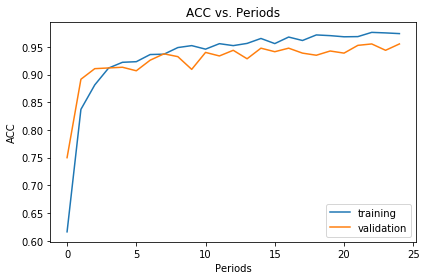

In [5]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00075), loss='categorical_crossentropy', metrics = ['acc'])

tensorboard = TensorBoard(log_dir='/tmp/training/{}'.format(time()))
history = model.fit(train_data,
                    t_labels,
                    validation_data=(validation_data, v_labels),
                    batch_size=64,
                    epochs=25,
                    callbacks=[tensorboard])

training_acc = history.history['acc']
validation_acc = history.history['val_acc']

print("Model training finished.")
model.save('model-V3.h5')
plt.ylabel("ACC")
plt.xlabel("Periods")
plt.title("ACC vs. Periods")
plt.tight_layout()
plt.plot(training_acc, label="training")
plt.plot(validation_acc, label="validation")
plt.legend()

In [6]:
print('Test accuracy after training is: {:.2f}%'.format(model.evaluate(test_data, test_labels)[1] * 100))

784/784 [==============================] - 0s 192us/sample - loss: 0.1892 - acc: 0.9503
Test accuracy after training is: 95.03%


In [7]:
def predict(features):
    logits = model.predict(features)[0]
    threshold = logits < .85
    logits[threshold] = 0
    if logits.sum() > 0:
        pred = np.argmax(logits)
        return(labels[pred], logits[pred])
    else:
        return(labels[5], .42)
    

In [8]:
sample_features  = test_data.sample()
sample_label = labels[np.argmax(test_labels.loc[[sample_features.index[0]]].values)]
start = time()
prediction, confidence = predict(sample_features)
end = time()
print('Label: {}, Prediction: {}, Confidence: {:.2f}, Pred_Time: {:.4f}'.format(sample_label,prediction,confidence,end-start))

Label: alpha, Prediction: alpha, Confidence: 1.00, Pred_Time: 0.1093


In [24]:
sample = pd.read_csv('sample.csv', index_col=0)
sample

,ch1,ch2,ch3,ch4
0,354.8,-195.2,4.2,91.3
1,402.7,-42.0,8.3,98.3
2,365.0,-141.8,12.5,99.7
3,365.8,-247.6,9.7,98.1
4,377.0,-187.0,7.0,101.2
5,357.5,-171.1,8.8,90.3
6,365.0,-141.8,12.5,99.7
7,368.9,-154.9,11.4,97.6
8,365.8,-247.6,9.7,98.1
9,377.0,-187.0,7.0,101.2


In [25]:
sample.transpose()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ch1,354.8,402.7,365.0,365.8,377.0,357.5,365.0,368.9,365.8,377.0,...,371.2,381.0,384.8,347.2,361.6,371.2,381.0,384.8,347.2,361.6
ch2,-195.2,-42.0,-141.8,-247.6,-187.0,-171.1,-141.8,-154.9,-247.6,-187.0,...,-125.2,-92.1,-152.1,-222.1,-174.3,-125.2,-92.1,-152.1,-222.1,-174.3
ch3,4.2,8.3,12.5,9.7,7.0,8.8,12.5,11.4,9.7,7.0,...,6.0,10.3,8.3,5.6,2.8,6.0,10.3,8.3,5.6,2.8
ch4,91.3,98.3,99.7,98.1,101.2,90.3,99.7,97.6,98.1,101.2,...,85.3,92.4,90.6,92.7,92.0,85.3,92.4,90.6,92.7,92.0


In [27]:
sample.transpose().values.flatten().reshape((1,200))

array([[ 3.5482e+02,  4.0271e+02,  3.6498e+02,  3.6584e+02,  3.7697e+02,
         3.5753e+02,  3.6498e+02,  3.6886e+02,  3.6584e+02,  3.7697e+02,
         3.7858e+02,  3.5753e+02,  3.5639e+02,  3.6886e+02,  3.7858e+02,
         3.7309e+02,  3.5639e+02,  3.7309e+02,  3.8152e+02,  3.8152e+02,
         3.6606e+02,  3.8077e+02,  3.7956e+02,  3.7216e+02,  3.6606e+02,
         3.4932e+02,  3.6458e+02,  3.8077e+02,  3.8583e+02,  3.7956e+02,
         3.7216e+02,  3.4932e+02,  3.6458e+02,  3.8583e+02,  3.9426e+02,
         3.6327e+02,  3.9426e+02,  3.7043e+02,  3.6327e+02,  3.7043e+02,
         3.7120e+02,  3.8101e+02,  3.8483e+02,  3.4720e+02,  3.6160e+02,
         3.7120e+02,  3.8101e+02,  3.8483e+02,  3.4720e+02,  3.6160e+02,
        -1.9520e+02, -4.1970e+01, -1.4179e+02, -2.4755e+02, -1.8696e+02,
        -1.7109e+02, -1.4179e+02, -1.5490e+02, -2.4755e+02, -1.8696e+02,
        -1.3097e+02, -1.7109e+02, -1.6796e+02, -1.5490e+02, -1.3097e+02,
        -1.5275e+02, -1.6796e+02, -1.5275e+02, -1.7

In [32]:
actions = range(5)
sum_actions = np.concatenate([np.repeat(val,2*ind) for ind, val in enumerate(actions)])
sum_actions

array([1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4])